<a href="https://colab.research.google.com/github/ShanmukhaManoj11/DL_experiments/blob/master/MobileNetV2_SSDLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.nn.init as init

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import sys
import itertools
from math import sqrt
import xml.etree.ElementTree as ET

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Utils

## VOC dataset configuration

In [3]:
voc={
    'image_size': 300, # input image size
    'name': 'VOC',
    'classes': {
        'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4, 'bottle':5, 'bus':6, 'car':7, 'cat':8, 'chair':9, 'cow':10,
        'diningtable':11, 'dog':12, 'horse':13, 'motorbike':14, 'person':15, 'pottedplant':16, 'sheep':17, 'sofa':18, 'train':19, 'tvmonitor':20
    }
}
class_list=list(voc['classes'].keys())

VOC07_BASE_DIR='drive/My Drive/Colab/VOC2007/'
VOC07_TRAIN_IMAGES_DIR='trainval/JPEGImages/'
VOC07_TRAIN_ANNOTATIONS_DIR='trainval/Annotations/'

VOC12_BASE_DIR='drive/My Drive/Colab/VOC2012/'
VOC12_TRAIN_IMAGES_DIR='JPEGImages/'
VOC12_TRAIN_ANNOTATIONS_DIR='Annotations/'

In [4]:
def parse_voc_annotation_xml(annotation_xml):
  '''
  @ parse annotation xml and output list of bounding boxes (relative coords)                                                        
  [[xmin1, ymin1, xmax1, ymax1, class_id1], [xmin2, ymin2, xmax2, ymax2, class_id2], ...]                                         
  '''
  annotation=[]
  root=ET.parse(annotation_xml).getroot()
  size=root.find('size')
  width=int(size.find('width').text)
  height=int(size.find('height').text)
  for obj in root.iter('object'):
    name=obj.find('name').text.lower().strip()
    bbox=obj.find('bndbox')
    xmin=float(bbox.find('xmin').text)/width
    ymin=float(bbox.find('ymin').text)/height
    xmax=float(bbox.find('xmax').text)/width
    ymax=float(bbox.find('ymax').text)/height
    annotation.append([xmin, ymin, xmax, ymax, voc['classes'][name]])
  return annotation

## VOC Dataset

In [5]:
class VOCDataset(data.Dataset):
  def __init__(self, roots, image_dirs, annotation_dirs, image_size=300, transforms=None):
    super(VOCDataset,self).__init__()
    self.roots = roots
    self.image_dirs = image_dirs
    self.annotation_dirs = annotation_dirs
    self.images, self.annotations = [], []
    for root, image_dir, annotation_dir in zip(roots, image_dirs, annotation_dirs):
      self.images += [root+image_dir+image for image in os.listdir(root+image_dir)]
      self.annotations += [root+annotation_dir+image[:-4]+'.xml' for image in os.listdir(root+image_dir)]
    self.image_size = image_size
    self.transforms = transforms
  
  def __len__(self):
    return len(self.images)
    
  def __getitem__(self, i):
    image = self.read_image(i)
    gt_labels = self.read_annotation(i)
    if self.transforms is not None:
      boxes = gt_labels[:,:-1]
      labels = gt_labels[:,-1]
      image, boxes, labels=self.transforms(image, boxes, labels)
      gt_labels = np.concatenate((boxes, np.expand_dims(labels,1)), 1)
    return torch.Tensor(image.copy()).permute(2,0,1), torch.Tensor(gt_labels)
  
  def read_image(self, i):
    #####################################################################################################################################
    # @ Read image                                                                                                                      #
    # imread -> convert color space BGR to RGB and image dtype to np.float32                                                            #
    #####################################################################################################################################
    image = cv2.imread(self.images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    return image
  
  def read_annotation(self, i):
    #####################################################################################################################################
    # @ Read annotations                                                                                                                #
    # parse annotation xml and return ground truth labels as numpy array of shape [n_boxes, 5]                                          #
    #   where each row is of format [xmin, ymin, xmax, ymax, class_id]                                                                  #
    # NOTE: box coords are relative to image size => box coords are in range [0,1]                                                      #
    #####################################################################################################################################
    gt_labels=parse_voc_annotation_xml(self.annotations[i])
    return np.array(gt_labels)

def voc_batch_collate(batch):
  #####################################################################################################################################
  # @ collate fn for dealing with batches with different sized annotations fpr data loader                                            #
  # input:                                                                                                                            #
  #   1. batch: list of tuple of image and annotation tensors                                                                         #
  # outut:                                                                                                                            #
  #   1. imgs: stacked batch of images of shape [batch_size, C, H, W]                                                                 #
  #   2. targets: list of annotation tensors                                                                                          #
  #####################################################################################################################################
  imgs,targets=[],[]
  for sample in batch:
    imgs.append(sample[0])
    targets.append(sample[1])
  return torch.stack(imgs,0), targets

### Dataset test

In [6]:
def show_image(ax, image, annotations=[], colors=[], class_list=[]):
  image_copy=image.copy()
  if annotations!=[] and len(colors)==len(annotations):
    for i, annotation in enumerate(annotations):
      for a in annotation:
        cv2.rectangle(image_copy, (int(a[0]), int(a[1])), (int(a[2]), int(a[3])), colors[i], 1)
        if len(a)==5 and class_list!=[]:
          if int(a[1])-6>0:
            cv2.putText(image_copy, class_list[int(a[4])-1], (int(a[0]), int(a[1])-2), cv2.FONT_HERSHEY_SIMPLEX, 0.3, colors[i], 1)
          else:
            cv2.putText(image_copy, class_list[int(a[4])-1], (int(a[0]), int(a[1])+5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, colors[i], 1)
  ax.imshow(image_copy)

In [7]:
voc_dataset=VOCDataset([VOC07_BASE_DIR, VOC12_BASE_DIR], [VOC07_TRAIN_IMAGES_DIR, VOC12_TRAIN_IMAGES_DIR], [VOC07_TRAIN_ANNOTATIONS_DIR, VOC12_TRAIN_ANNOTATIONS_DIR], image_size=voc['image_size'])
print('dataset size =', len(voc_dataset))

dataset size = 22136


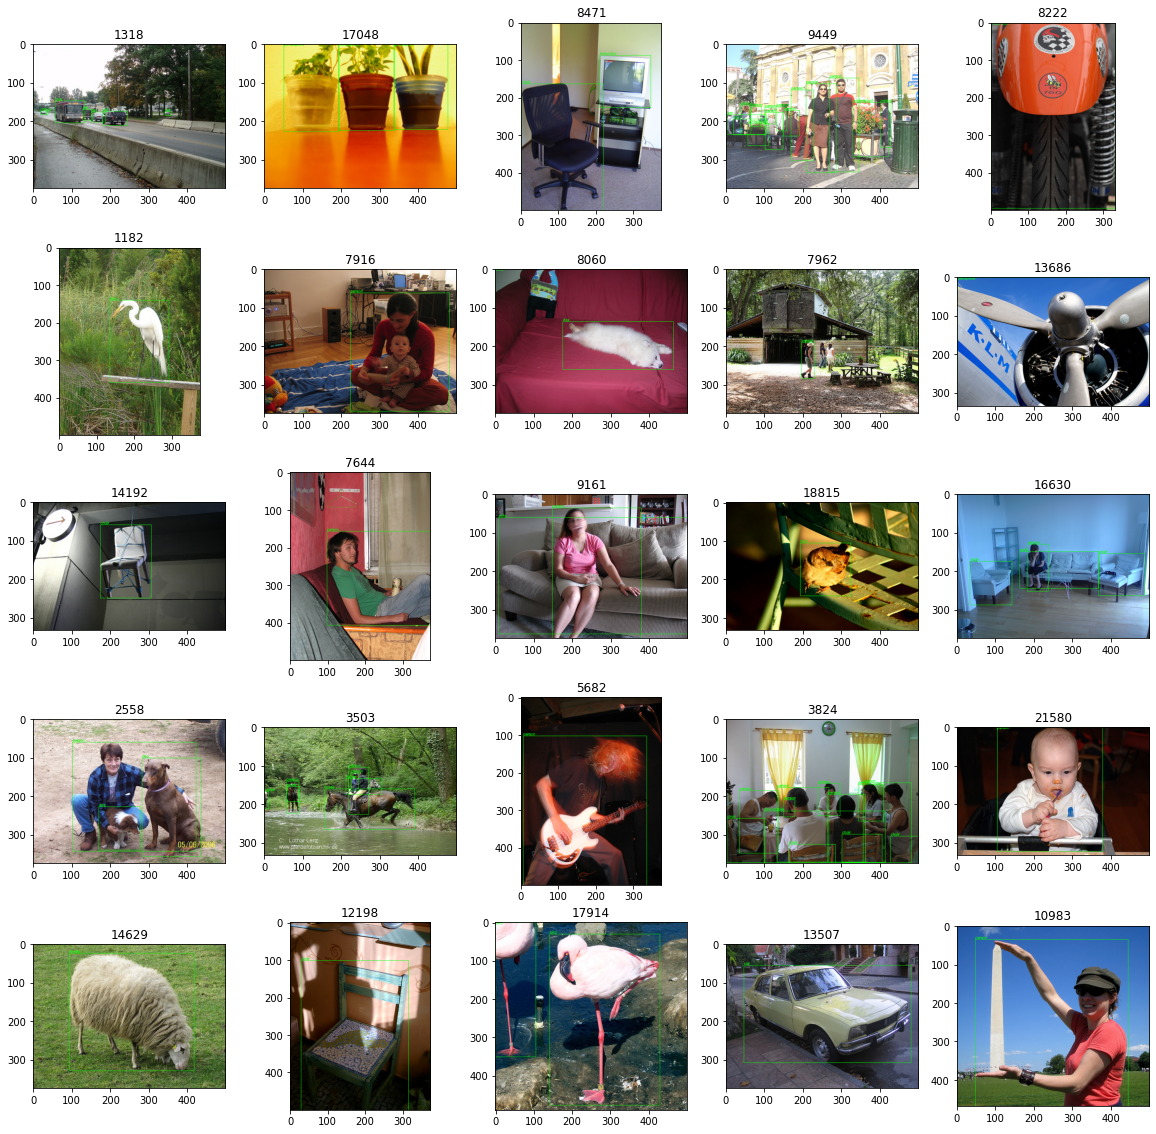

In [8]:
nrows, ncols = 5, 5
fig,ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[20,20])
rng = np.random.RandomState(1234)
for r in range(nrows):
  for c in range(ncols):
    sample_id=rng.randint(len(voc_dataset))
    image, gt_labels = voc_dataset[sample_id]

    #gt_labels contain relative coordinates for bounding boxes, converting them to absolute
    gt_labels[:,0:4:2] *= image.size(2)
    gt_labels[:,1:4:2] *= image.size(1)
    # image shape = [C, H, W] (torch format) -> permute to [H, W, C] (numpy/ cv format)
    show_image(ax[r,c], image.permute(1,2,0).numpy()/255.0, annotations=[gt_labels], colors=[(0,1,0)], class_list=class_list)
    ax[r,c].set_title(str(sample_id))

## Data transforms and augmentations

In [9]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
# Transforms and Augmentations that can be performed on the images and boxes data in numpy format

class Compose(object):
  '''
  @ Compose augmentations to be applied sequentially                                                                                
  Args:                                                                                                                             
    1. transforms: list of transforms to be applied                                                                                   
  Example:                                                                                                                          
    Compose([transform1, transform2, ...])                                                                                          
  '''
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, image, boxes=None, labels=None):
    for transform in self.transforms:
      image, boxes, labels = transform(image, boxes, labels)
    return image, boxes, labels

class SubtractMean(object):
  def __init__(self, mean):
    self.mean = np.array(mean, dtype=np.float32)
  
  def __call__(self, image, boxes=None, labels=None):
    # input image dtype should be np.float32
    image -= self.mean
    return image, boxes, labels

class ToAbsoluteCoords(object):
  def __call__(self, image, boxes=None, labels=None):
    h, w, _=image.shape
    if boxes is not None:
      boxes[:,0] *= w
      boxes[:,1] *= h
      boxes[:,2] *= w
      boxes[:,3] *= h
    return image, boxes, labels

class ToRelativeCoords(object):
  def __call__(self, image, boxes=None, labels=None):
    h, w, _=image.shape
    if boxes is not None:
      boxes[:,0] /= w
      boxes[:,1] /= h
      boxes[:,2] /= w
      boxes[:,3] /= h
    return image, boxes, labels

class Resize(object):
  def __init__(self, size=300):
    self.size = size
  
  def __call__(self, image, boxes=None, labels=None):
    image = cv2.resize(image, (self.size, self.size))
    return image, boxes, labels

class Scale(object):
  def __init__(self, scale=255.0):
    self.scale = scale

  def __call__(self, image, boxes=None, labels=None):
    # input image is of type np.float32 and returns scaled input image where each pixel is divided by scale value
    image /= self.scale
    return image, boxes, labels

class RandomSaturation(object):
  def __init__(self, low=0.5, high=1.5):
    self.low = low
    self.high = high
  
  def __call__(self, image_hsv, boxes=None, labels=None):
    # input image is expected to be in HSV color space
    if np.random.randint(2):
      image_hsv[:,:,1] *= np.random.uniform(self.low, self.high)
    return image_hsv, boxes, labels

class RandomHue(object):
  def __init__(self, delta=18.0):
    self.delta = delta

  def __call__(self, image_hsv, boxes=None, labels=None):
    # input image is expected to be in HSV color space
    if np.random.randint(2):
      image_hsv[:,:,0] += np.random.uniform(-self.delta, self.delta)
      image_hsv[:,:,0][image_hsv[:,:,0] > 360.0] -= 360.0
      image_hsv[:,:,0][image_hsv[:,:,0] < 0.0] += 360.0
    return image_hsv, boxes, labels

class SwapChannels(object):
  def __init__(self, swaps):
    self.swaps = swaps 
  
  def __call__(self, image):
    image = image[:,:,self.swaps]
    return image

class RandomLightingNoise(object):
  def __init__(self):
    self.perms = ((0,1,2), (0,2,1), (1,0,2), (1,2,0), (2,0,1), (2,1,0))
  
  def __call__(self, image, boxes=None, labels=None):
    if np.random.randint(2):
      swap = self.perms[np.random.randint(len(self.perms))]
      shuffle = SwapChannels(swap)
      image = shuffle(image)
    return image, boxes, labels

class ConvertColorSpace(object):
  def __init__(self, current='RGB', to='HSV'):
    self.current = current
    self.to = to
  
  def __call__(self, image, boxes=None, labels=None):
    if self.current=='RGB' and self.to=='HSV':
      image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif self.current=='HSV' and self.to=='RGB':
      image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    else:
      raise NotImplementedError
    return image, boxes, labels
  
class RandomContrast(object):
  def __init__(self, low=0.5, high=1.5):
    self.low=0.5
    self.high=1.5

  def __call__(self, image, boxes=None, labels=None):
    # input image should be of type floats
    if np.random.randint(2):
      image *= np.random.uniform(self.low, self.high)
    return image, boxes, labels

class RandomBrightness(object):
  def __init__(self, delta=32.0):
    self.delta = delta
  
  def __call__(self, image, boxes=None, labels=None):
    if np.random.randint(2):
      image += np.random.uniform(-self.delta, self.delta)
    return image, boxes, labels

def intersection_np(boxes1, box2):
  '''
  @ Compute intersection area of each box1 in boxes1 with box2                                                                      
  input:                                                                                                                            
    1. boxes1: numpy array of boxes of shape [n_boxes1, 4], each row of form [xmin, ymin, xmax, ymax]                               
    2. box2: target box of shape [4], of form [xmin, ymin, xmax, ymax]                                                              
  output:                                                                                                                           
    1. intersection_area: shape [n_boxes1] with intersection_area[i] = intersection area of ith box1 in boxes1 with target box box2 
  '''
  min_xy = np.maximum(boxes1[:,:2], box2[:2])
  max_xy = np.minimum(boxes1[:,2:], box2[2:])
  intersection_ = np.clip((max_xy-min_xy), a_min=0, a_max=np.inf)
  return intersection_[:,0]*intersection_[:,1]

def IOU_np(boxes1, box2):
  intersection_area = intersection_np(boxes1, box2)
  area1 = (boxes1[:,2]-boxes1[:,0])*(boxes1[:,3]-boxes1[:,1])
  area2 = (box2[2]-box2[0])*(box2[3]-box2[1])
  union_area = area1 + area2 - intersection_area
  return intersection_area/union_area

class RandomSampleCrop(object):
  def __init__(self):
    self.sample_options=(
        None, # using entire original image
        (0.1, None), # sample a patch such that min jaccard overlap (IOU) with gt boxes of 0.1
        (0.3, None),
        (0.7, None),
        (0.9, None),
        (None, None) # randomly sample a patch
    )
  
  def __call__(self, image, boxes=None, labels=None):
    if boxes is not None:
      height, width, _=image.shape
      mode = np.random.choice(self.sample_options)
      if mode is None:
        return image, boxes, labels
      min_iou, max_iou=mode
      if min_iou is None:
        min_iou = float('-inf')
      if max_iou is None:
        max_iou = float('inf')

      for _ in range(50):
        current_image = image
        w = np.random.uniform(0.3*width, width)
        h = np.random.uniform(0.3*height, height)

        aspect_ratio=(h/w)
        if (aspect_ratio<0.5) or (aspect_ratio>2):
          continue
        
        left = np.random.uniform(width-w)
        top = np.random.uniform(height-h)
        rect = np.array([int(left), int(top), int(left+w), int(top+h)])
        overlap = IOU_np(boxes, rect)
        if (overlap.min()<min_iou) or (overlap.max()>max_iou):
          continue 
        current_image = current_image[rect[1]:rect[3], rect[0]:rect[2], :]

        centers=(boxes[:,:2]+boxes[:,2:])/2.0
        m1 = (rect[0]<centers[:,0])*(rect[1]<centers[:,1])
        m2 = (rect[2]>centers[:,0])*(rect[3]>centers[:,1])
        mask = m1*m2
        if not mask.any():
          continue
        
        current_boxes = boxes[mask,:].copy()
        current_boxes[:,:2] = np.maximum(current_boxes[:,:2], rect[:2])
        current_boxes[:,:2] -= rect[:2]
        current_boxes[:,2:] = np.minimum(current_boxes[:,2:], rect[2:])
        current_boxes[:,2:] -= rect[:2]

        current_labels = labels[mask]
        return current_image, current_boxes, current_labels

    return image, boxes, labels

class RandomMirror(object):
  def __call__(self, image, boxes, labels):
    _, width, _=image.shape
    if np.random.randint(2):
      image = np.flip(image, axis=1)
      boxes[:,0::2] = width-boxes[:,2::-2]
    return image, boxes, labels

class PhotometricDistort(object):
  def __init__(self):
    self.distort_transforms = [
                               RandomContrast(),
                               ConvertColorSpace(to='HSV'),
                               RandomSaturation(),
                               RandomHue(),
                               ConvertColorSpace(current='HSV', to='RGB'),
                               RandomContrast()
    ]
    self.rand_brightness = RandomBrightness()
    self.rand_light_noise = RandomLightingNoise()

  def __call__(self, image, boxes, labels):
    image, boxes, labels=self.rand_brightness(image, boxes, labels)
    if np.random.randint(2):
      dist_transforms=Compose(self.distort_transforms[:-1])
    else:
      dist_transforms=Compose(self.distort_transforms[1:])
    image, boxes, labels=dist_transforms(image, boxes, labels)
    image, boxes, labels=self.rand_light_noise(image, boxes, labels)
    return image, boxes, labels

In [10]:
class SSDAugmentation(object):
  def __init__(self, size=300, mean=(127.0, 127.0, 127.0), scale=128.0):
    self.size = size
    self.mean = mean
    self.scale = scale
    self.augmentations = Compose([
                                  PhotometricDistort(), # NOTE: operation doesnot impact box coordinates
                                  ToAbsoluteCoords(), # convert box coordinates to absolute based on input image height and width
                                  RandomSampleCrop(), # NOTE: operation impacts box coordinates
                                  RandomMirror(), # NOTE: operation impacts box coordinates
                                  ToRelativeCoords(), # convert box coordinates to relative based on resized image
                                  SubtractMean(self.mean), # NOTE: operation doesnot impact box coordinates
                                  Resize(self.size), # NOTE: operation doesnot impact box coordinates
                                  Scale(self.scale) # scale image data by dividing with 255.0, NOTE: operation doesnot impact box coordinates
    ])
  
  def __call__(self, image, boxes, labels):
    return self.augmentations(image, boxes, labels)

### Augmentations test

In [11]:
voc_dataset=VOCDataset([VOC07_BASE_DIR, VOC12_BASE_DIR], [VOC07_TRAIN_IMAGES_DIR, VOC12_TRAIN_IMAGES_DIR], [VOC07_TRAIN_ANNOTATIONS_DIR, VOC12_TRAIN_ANNOTATIONS_DIR], image_size=voc['image_size'], transforms=SSDAugmentation())

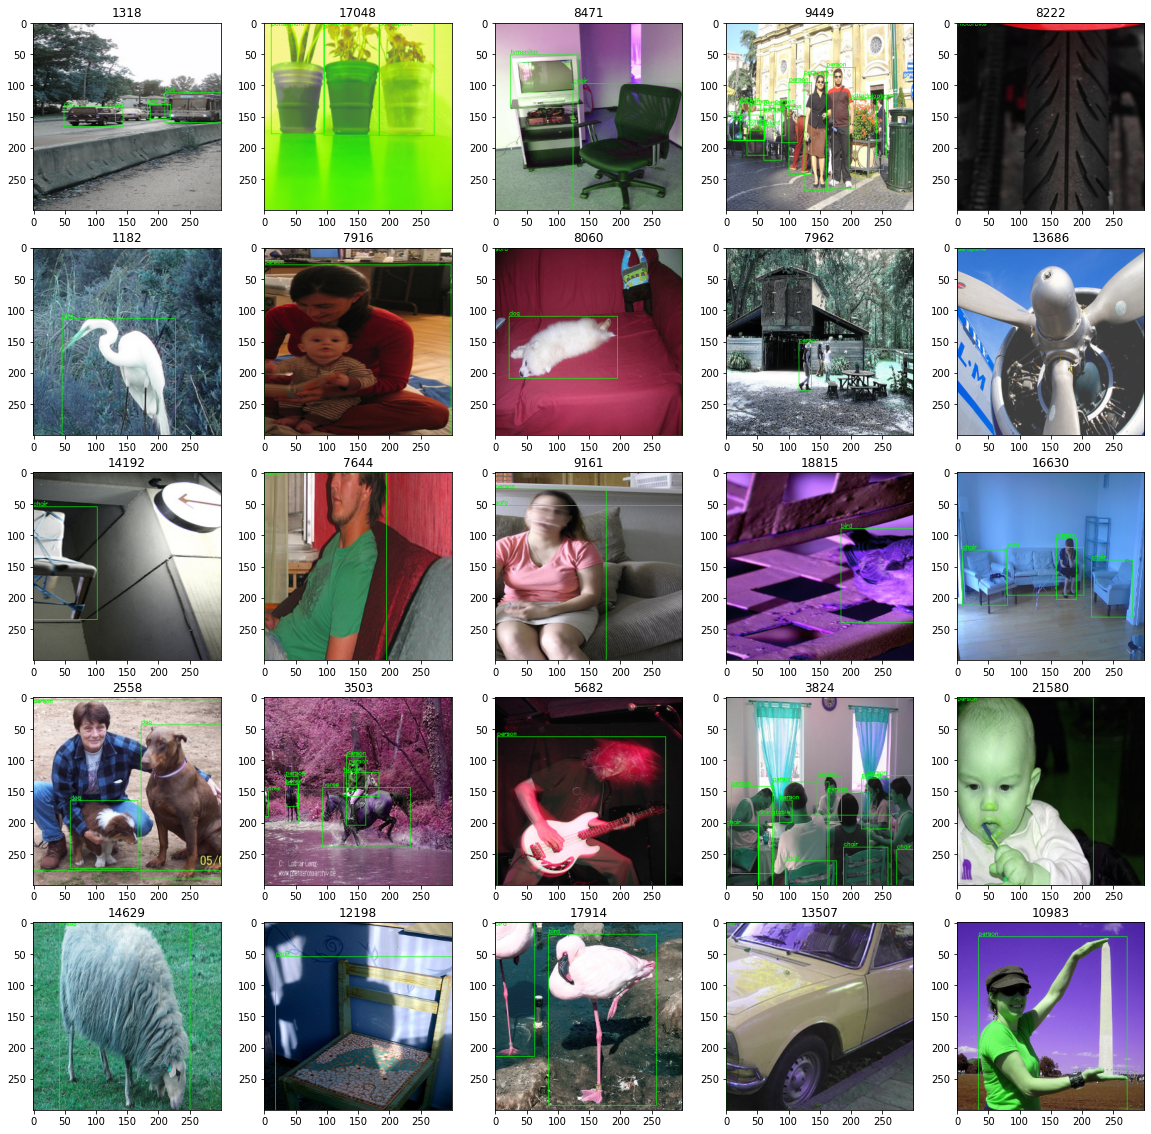

In [12]:
nrows, ncols = 5, 5
fig,ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[20,20])
rng = np.random.RandomState(1234)
for r in range(nrows):
  for c in range(ncols):
    sample_id=rng.randint(len(voc_dataset))
    image, gt_labels = voc_dataset[sample_id]
    assert image.size(0)==3
    assert image.size(1)==voc['image_size']
    assert image.size(2)==voc['image_size']

    #gt_labels contain relative coordinates for bounding boxes, converting them to absolute
    gt_labels[:,0:4:2] *= image.size(2)
    gt_labels[:,1:4:2] *= image.size(1)
    # image shape = [C, H, W] (torch format) -> permute to [H, W, C] (numpy/ cv format)
    image=image.permute(1,2,0).numpy()
    image=(image-image.min())/(image.max()-image.min())
    show_image(ax[r,c], image, annotations=[gt_labels], colors=[(0,1,0)], class_list=class_list)
    ax[r,c].set_title(str(sample_id))

# MobileNetV2-SSDLite

Ref: https://github.com/qfgaohao/pytorch-ssd

## Default boxes

In [13]:
# default boxes per feature map of SSDLite with MobileNetV2 as backend
default_boxes_setting = {
    'feature_map_sizes': [19, 10, 5, 3, 2, 1], # sizes of feature maps, a => feature map has axa cells
    'aspect_ratios': [[2,3], [2,3], [2,3], [2,3], [2,3], [2,3]], # aspect ratio of default boxes for each feature map, [a,b] => aspect ratios of 1, a, 1/a, b, 1/b are included
    'scales': [0.2, 0.35, 0.5, 0.65, 0.8, 0.95, 1.1], # relative scales of boxes (with respect to input image size) at each feature map scale, len(scales) = number of feature maps + 1 as at aspect ratio 1 two default boxes of scales s_k and sqrt(s_k * s_<k+1>) are included
}

In [14]:
def get_default_boxes(config):
  '''
  @ return default boxes for SSD network given feature map sizes, aspect ratios, scales
  return a tensor of shape [n_priors, 4] - each row is of form [cx, cy, w, h] relative to input image size
  for MobileNetV2 as backend, n_priors = (19^2 * 6 + 10^2 * 6 + 5^2 * 6 + 3^2 * 6 + 2^2 * 6 + 1^2 * 6) = 3000
    [19, 10, 5, 3, 2, 1] are feaute map sizes at multiple scales and each cell in a feature map has 6 defaults boxes
  '''
  feature_map_sizes = config['feature_map_sizes']
  aspect_ratios = config['aspect_ratios']
  scales = config['scales']
  default_boxes = []
  for k, fs in enumerate(feature_map_sizes):
    for i, j in itertools.product(range(fs), repeat=2):
      cx, cy = (j+0.5)/fs, (i+0.5)/fs

      s_k = scales[k]
      default_boxes.append([cx, cy, s_k, s_k])
      
      s_kp1 = sqrt(s_k * scales[k+1])
      default_boxes.append([cx, cy, s_kp1, s_kp1])

      for ar in aspect_ratios[k]:
        default_boxes.append([cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)])
        default_boxes.append([cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)])
  
  default_boxes = torch.Tensor(default_boxes).clamp_(0, 1)
  return default_boxes

In [15]:
default_boxes = get_default_boxes(default_boxes_setting)
print(default_boxes.size())

torch.Size([3000, 4])


## nn Module utils

In [16]:
def conv2d_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1, use_bias=False, use_batch_norm=True):
  '''
  @ combined util to apply conv2d -> batch norm 2d (No activation)
  input:
    1. in_channels: number of input channels
    2. out_channels: number of output channels 
    3. kernel_size: kernel size for conv2d operation                                                                            
    4. stride: stride for conv2d                                                                                                
    5. padding: padding value for conv2d operation                                                                              
    6. groups: groups value for defining connection between input and output channels                                           
               when groups = in_channels, performs depthwise operation                                                         
    7. use_bias: boolean variable to specify if bias is needed in the conv2d operation                                          
    8. use_batch_norm: boolean variable to specify if batch norm is applied after the conv2d operation                          
  '''
  if use_batch_norm:
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups, bias=use_bias),
        nn.BatchNorm2d(out_channels)
    )
  else:
    nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups, bias=use_bias)

def conv2d_bn_relu(in_channels, out_channels, kernel_size, stride, padding, groups=1, use_bias=False, use_batch_norm=True, onnx_compatible=False):
  '''
  @ combined util to apply conv2d -> batch norm 2d -> relu
  input:
    1. in_channels: number of input channels
    2. out_channels: number of output channels 
    3. kernel_size: kernel size for conv2d operation                                                                            
    4. stride: stride for conv2d                                                                                                
    5. padding: padding value for conv2d operation                                                                              
    6. groups: groups value for defining connection between input and output channels                                           
               when groups = in_channels, performs depthwise operation                                                         
    7. use_bias: boolean variable to specify if bias is needed in the conv2d operation                                          
    8. use_batch_norm: boolean variable to specify if batch norm is applied after the conv2d operation   
    9. onnx_compatible: boolean variable that specifies the use of ReLU or ReLU6                       
  '''
  ReLU = nn.ReLU if onnx_compatible else nn.ReLU6

  if use_batch_norm:
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups, bias=use_bias),
        nn.BatchNorm2d(out_channels),
        ReLU(inplace=True)
    )
  else:
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups, bias=use_bias),
        ReLU(inplace=True)
    )

### Separable Convolution

In [17]:
def SeparableConv2d(in_channels, out_channels, kernel_size, stride, padding, onnx_compatible=False):
  '''
  Conv2d as depthwise and pointwise convolution operations
  '''
  return nn.Sequential(
      # depthwise operation
      conv2d_bn_relu(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, use_bias=True, use_batch_norm=True, onnx_compatible=onnx_compatible),
      # pointwise linear operation
      nn.Conv2d(in_channels, out_channels, 1)
  )

### Inverted residual bottleneck module

In [18]:
class InvertedResidualBottleneck(nn.Module):
  '''
  @ Inverted residual bottleneck module - basic block of the mobilenetV2 architecture
  '''
  def __init__(self, in_channels, out_channels, stride, expansion_ratio, use_batch_norm=True, onnx_compatible=False):
    super(InvertedResidualBottleneck, self).__init__()
    hidden_channels = round(expansion_ratio*in_channels)
    self.residual_connection = (stride==1 and in_channels==out_channels)

    if expansion_ratio==1:
      self.operation=nn.Sequential(
          # depthwise operation: notice groups=in_channels
          conv2d_bn_relu(in_channels, in_channels, 3, stride, 1, groups=in_channels, use_bias=False, use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible),
          # pointwise "linear" operation: no ReLU activation
          conv2d_bn(in_channels, out_channels, 1, 1, 0, use_bias=False)
      )
    else:
      self.operation=nn.Sequential(
          # pointwise operation for expansion based on expansion_ratio
          conv2d_bn_relu(in_channels, hidden_channels, 1, 1, 0, use_bias=False, use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible),
          # depthwise operation
          conv2d_bn_relu(hidden_channels, hidden_channels, 3, stride, 1, groups=hidden_channels, use_bias=False, use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible),
          # pointwise "linear" operation
          conv2d_bn(hidden_channels, out_channels, 1, 1, 0, use_bias=False)
      )
  
  def forward(self, x):
    if self.residual_connection:
      return x + self.operation(x)
    else:
      return self.operation(x)

## MobileNetV2

In [19]:
class MobileNetV2(nn.Module):
  '''
  @ MobileNetV2 architecture
  https://arxiv.org/pdf/1801.04381.pdf
  '''
  def __init__(self, n_classes=1000, width_multiplier=1.0, dropout_ratio=0.2, use_batch_norm=True, onnx_compatible=False):
    super(MobileNetV2, self).__init__()
    self.n_classes = n_classes
    # layout defines the structure of the inverted residual bottleneck blocks
    layout = [
              # t, c, n, s
              [1, 16, 1, 1],
              [6, 24, 2, 2],
              [6, 32, 3, 2],
              [6, 64, 4, 2],
              [6, 96, 3, 1],
              [6, 160, 3, 2],
              [6, 320, 1, 1]
    ]

    # add first standard conv(3x3)+bn+relu module converting input 3 channels to 32*width_multiplier channels
    self.features = [conv2d_bn_relu(3, int(32*width_multiplier), 3, 2, 1, groups=1, use_bias=False, use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible)]
    # add inverted residual bottleneck modules
    in_channels = int(32*width_multiplier)
    for t, c, n, s in layout:
      out_channels = int(c*width_multiplier)
      for i in range(n):
        if i==0:
          self.features.append(InvertedResidualBottleneck(in_channels, out_channels, s, t, use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible))
        else:
          self.features.append(InvertedResidualBottleneck(in_channels, out_channels, 1, t, use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible))
        in_channels = out_channels
    # add standard conv(1x1)+bn+relu module
    out_channels = int(1280*width_multiplier) if width_multiplier>1.0 else 1280
    self.features.append(conv2d_bn_relu(in_channels, out_channels, 1, 1, 0, groups=1, use_bias=False, use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible))
    self.features = nn.ModuleList(self.features)

    self.classifier = nn.Sequential(
        nn.Dropout(dropout_ratio),
        nn.Conv2d(out_channels, n_classes, 1, stride=1, padding=0)
    )

    self.initialize_weights()

  def forward(self, x):
    for op in self.features:
      x=op(x)
    x = nn.AvgPool2d(7)(x)
    x = self.classifier(x).view(-1,self.n_classes)
    return x
  
  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, sqrt(2.0/n))
        if m.bias is not None:
          m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.01)
        m.bias.data.zero_()

## SSDLite with MobileNetV2 base

In [20]:
def mobilenetv2_base(width_multiplier=1.0, use_batch_norm=True, onnx_compatible=False):
  '''
  @ return "features" from MobileNetV2
  '''
  return MobileNetV2(width_multiplier=width_multiplier, use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible).features

def auxiliary_layers(in_channels):
  '''
  @ return auxiliary modules to be sequentially added at the end of the base layers
  input: in_channels = out_channels of the last layer of the base layers
  '''
  return nn.ModuleList([
      InvertedResidualBottleneck(in_channels, 512, 2, expansion_ratio=0.2),
      InvertedResidualBottleneck(512, 256, 2, expansion_ratio=0.25),
      InvertedResidualBottleneck(256, 256, 2, expansion_ratio=0.5),
      InvertedResidualBottleneck(256, 64, 2, expansion_ratio=0.25)
  ])

def predictors(base_layers, n_classes=21, onnx_compatible=False):
  '''
  @ return modules responsible for predicting localization offsets and class confidences as tuple of module lists
  With MobileNetV2 as base network for SSD, output 15th (of the base layers) layer's expansion layer and last layer's output are used as feature maps for predictions
    along with the auxiliary layers 
  '''
  in_channels1 = base_layers[14].operation[0][0].out_channels
  in_channels2 = base_layers[-1][0].out_channels
  loc_layers = nn.ModuleList([
      SeparableConv2d(in_channels1, 6*4, 3, 1, 1, onnx_compatible=onnx_compatible),
      SeparableConv2d(in_channels2, 6*4, 3, 1, 1, onnx_compatible=onnx_compatible),
      SeparableConv2d(512, 6*4, 3, 1, 1, onnx_compatible=onnx_compatible),
      SeparableConv2d(256, 6*4, 3, 1, 1, onnx_compatible=onnx_compatible),
      SeparableConv2d(256, 6*4, 3, 1, 1, onnx_compatible=onnx_compatible),
      nn.Conv2d(64, 6*4, 1)
  ])

  conf_layers = nn.ModuleList([
      SeparableConv2d(in_channels1, 6*n_classes, 3, 1, 1, onnx_compatible=onnx_compatible),
      SeparableConv2d(in_channels2, 6*n_classes, 3, 1, 1, onnx_compatible=onnx_compatible),
      SeparableConv2d(512, 6*n_classes, 3, 1, 1, onnx_compatible=onnx_compatible),
      SeparableConv2d(256, 6*n_classes, 3, 1, 1, onnx_compatible=onnx_compatible),
      SeparableConv2d(256, 6*n_classes, 3, 1, 1, onnx_compatible=onnx_compatible),
      nn.Conv2d(64, 6*n_classes, 1)
  ])
  return loc_layers, conf_layers

In [21]:
class SSDLite(nn.Module):
  '''
  @ SSD network with "features" from MobileNetV2 as base layers
  '''
  def __init__(self, base_layers, auxiliary_layers, loc_layers, conf_layers, n_classes=21):
    '''
    @ constructor
    inputs:
      1. base_layers: base layers (features) from MobileNetV2 as nn.ModuleList
      2. auxiliary_layers: extra layers sequentially added to last base layer as nn.ModuleList
      3. loc_layers: operations responsible for predicting localization offsets as nn.ModuleList
      4. conf_layers: operations responsible for predicting class confidences as nn.ModuleList
    '''
    super(SSDLite, self).__init__()
    self.base_layers=base_layers
    self.auxiliary_layers=auxiliary_layers
    self.loc_layers=loc_layers
    self.conf_layers=conf_layers
    self.n_classes=n_classes
  
  def forward(self, x):
    '''
    feature maps used for predicitng localization offsets and classes
      1. output from expansion of 15th layer from base layers (NOTE: index starts from 0)
      2. output from last layer of base layers
      3. output from all auxiliary layers
    '''
    pred_feature_maps=[]
    # forward pass on base layers till 15th layer and cache output of layer 15's expansion operation to use for predictions in pred_feature_maps list
    for k in range(14):
      x=self.base_layers[k](x)
    x=self.base_layers[14].operation[0](x)
    pred_feature_maps.append(x)
    # forward pass on remaining layers of base network and cache last layer output to use for predictions in pred_feature_maps list
    for op in self.base_layers[14].operation[1:]:
      x=op(x)
    for k in range(15, len(self.base_layers)):
      x=self.base_layers[k](x)
    pred_feature_maps.append(x)
    # forward pass on auxiliary layers and cache intermediate layers to be used for prediction in pred_feature_maps list
    for aux in self.auxiliary_layers:
      x=aux(x)
      pred_feature_maps.append(x)
    # use cached layers for prediction
    loc, conf=[],[]
    for feature_map, loc_layer, conf_layer in zip(pred_feature_maps, self.loc_layers, self.conf_layers):
      loc.append(loc_layer(feature_map).permute(0,2,3,1).contiguous())
      conf.append(conf_layer(feature_map).permute(0,2,3,1).contiguous())
    loc=torch.cat([o.view(o.size(0), -1) for o in loc], 1)
    conf=torch.cat([o.view(o.size(0), -1) for o in conf], 1)
    return loc.view(loc.size(0),-1,4), conf.view(conf.size(0),-1,self.n_classes)

In [22]:
def build_MobileNetV2_SSDLite(n_classes=21, width_multiplier=1.0, use_batch_norm=True, onnx_compatible=False):
  base_layers = mobilenetv2_base(width_multiplier=width_multiplier, use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible)

  in_channels = base_layers[-1][0].out_channels
  aux_layers = auxiliary_layers(in_channels)

  loc_layers, conf_layers = predictors(base_layers, n_classes=n_classes, onnx_compatible=onnx_compatible)

  return SSDLite(base_layers, aux_layers, loc_layers, conf_layers, n_classes=n_classes)

### Architecture test

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [24]:
ssd=build_MobileNetV2_SSDLite()
ssd.to(device)

SSDLite(
  (base_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidualBottleneck(
      (operation): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidualBottleneck(
      (operation): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

In [25]:
batch_size = 4
voc_dataloader = data.DataLoader(voc_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=voc_batch_collate)

iterator = iter(voc_dataloader)
for i in range(1):
  try:
    images, gt_labels = next(iterator)
  except StopIteration:
    iterator = iter(voc_dataloader)
    images, gt_labels = next(iterator)
  images = images.to(device)
  loc_pred, conf_pred = ssd(images)
  print(loc_pred.size(), conf_pred.size())

torch.Size([4, 3000, 4]) torch.Size([4, 3000, 21])


# Multibox loss

## Box utils

In [26]:
def to_minmaxformat(boxes_cxcywh):
  '''
  @ convert boxes of form (cx, cy, w, h) to (xmin, ymin, xmax, ymax) form                                                           
  input:                                                                                                                            
    1. boxes_cxcywh: tensor of shape [n_boxes, 4], each row of form [cx, cy, w, h]                                                  
  output:                                                                                                                           
    2. tensor of shape [n_boxes, 4], each row of form [xmin, ymin, xmax, ymax]                                                      
  '''
  return torch.cat((boxes_cxcywh[:,:2] - boxes_cxcywh[:,2:]/2.0, boxes_cxcywh[:,:2] + boxes_cxcywh[:,2:]/2.0), 1)

def to_cxcywhformat(boxes_minmax):
  '''
  @ convert boxes of form (xmin, ymin, xmax, ymax) to (cx, cy, w, h) form                                                           
  input:                                                                                                                            
    1. boxes_minmax: tensor of shape [n_boxes, 4], each row of form [xmin, ymin, xmax, ymax]                                        
  output:                                                                                                                           
    2. tensor of shape [n_boxes, 4], each row of form [cx, cy, w, h]                                                                
  '''
  return torch.cat(((boxes_minmax[:,:2] + boxes_minmax[:,2:])/2.0, boxes_minmax[:,2:] - boxes_minmax[:,:2]), 1)

def intersection(boxes1, boxes2):
  '''
  @ compute intersection area of pairs {boxes1[i], boxes2[j]} for all (i,j) pairs                                                   
  input:                                                                                                                            
    1. boxes1: tensor of shape [n1, 4] where each row is in form [xmin, ymin, xmax, ymax]                                           
    2. boxes2: tensor of shape [n2, 4] where each row is in form [xmin, ymin, xmax, ymax]                                           
  output:                                                                                                                           
    1. intersection area: tensor of shape [n1, n2] where element at (i,j) corresponds to intersection area of boxes1[i], boxes2[j]  
  '''
  n1, n2=boxes1.shape[0], boxes2.shape[0]
  min_xy=torch.max(boxes1[:,:2].unsqueeze(1).expand(n1,n2,2), boxes2[:,:2].unsqueeze(0).expand(n1,n2,2))
  max_xy=torch.min(boxes1[:,2:].unsqueeze(1).expand(n1,n2,2), boxes2[:,2:].unsqueeze(0).expand(n1,n2,2))
  intersection_=torch.clamp((max_xy-min_xy), min=0)
  return intersection_[:,:,0]*intersection_[:,:,1]

def IOU(boxes1, boxes2):
  '''
  @ compute IOU score of pairs {boxes1[i], boxes2[j]} for all (i,j) pairs                                                           
  input:                                                                                                                            
    1. boxes1: tensor of shape [n1, 4] where each row is in form [xmin, ymin, xmax, ymax]                                           
    2. boxes2: tensor of shape [n2, 4] where each row is in form [xmin, ymin, xmax, ymax]                                           
  output:                                                                                                                           
    1. IOU: tensor of shape [n1, n2] where element at (i,j) corresponds to IOU of boxes1[i], boxes2[j]                              
  '''
  intersection_area=intersection(boxes1, boxes2)
  area1=((boxes1[:,2]-boxes1[:,0])*(boxes1[:,3]-boxes1[:,1])).unsqueeze(1).expand_as(intersection_area)
  area2=((boxes2[:,2]-boxes2[:,0])*(boxes2[:,3]-boxes2[:,1])).unsqueeze(0).expand_as(intersection_area)
  union_area=area1+area2-intersection_area
  return intersection_area/union_area

## Matching strategy for associating ground truth labels to default boxes

In [27]:
def matching_strategy(gt_labels, default_boxes, overlap_threshold=0.5):
  '''
  @ Associate ground truth labels to default boxes and assign targets for training                                                  
  input:                                                                                                                            
    1. gt_labels: ground truth labels - tensor of shape [n_gt, 5]                                                                   
        each row is of form [xmin, ymin, xmax, ymax, class]                                                                           
    2. default_boxes: default boxes - tensor of shape [n_priors, 4] each row in format [xmin, ymin, xmax, ymax]                     
    3. overlap_threshold: minimum IOU between default box and gt box to consider as positve match                                   
  output:                                                                                                                           
    1. target_boxes: target box offsets for training - tensor of shape [n_priors, 4], each row in format [xmin, ymin, xmax, ymax]   
    2. target_classes: target classes - tensor of shape [n_priors]                                                                  
        NOTE: 0 for background and actual classes starts with 1                                                                       
  '''
  gt_boxes=gt_labels[:,:-1] # [n_gt, 4]
  gt_classes=gt_labels[:,-1] # [n_gt]
  ious=IOU(gt_boxes, default_boxes) # [n_gt, n_priors]
  best_gt_iou_for_defaultbox, best_gt_id_for_defaultbox=ious.max(0) # [n_priors]
  # best_gt_iou_for_defaultbox[i] = max IOU of the ith default box with all ground truth boxes
  # best_gt_id_for_defaultbox[i] = ID of the ground truth box that has max IOU with the ith default box
  _, best_defaultbox_id_for_gt=ious.max(1) # [n_gt]
  # best_defaultbox_id_for_gt[j] = id of the default box that has max IOU with the jth ground truth box
  n_gt=gt_boxes.size(0)
  # make sure that each gt_box is assigned to a default box
  best_gt_id_for_defaultbox[best_defaultbox_id_for_gt]=torch.LongTensor(range(n_gt))
  best_gt_iou_for_defaultbox[best_defaultbox_id_for_gt]=1.0
  # target boxes
  target_boxes=gt_boxes[best_gt_id_for_defaultbox] # [n_priors, 4]
  # target classes
  target_classes=gt_classes[best_gt_id_for_defaultbox] # [n_priors]
  # label classes as negative/ background if IOU < threshold
  target_classes[best_gt_iou_for_defaultbox < overlap_threshold]=0
  return target_boxes, target_classes

## Encode target boxes as offsets to default boxes

In [28]:
def encode_targets(target_boxes, default_boxes, std=torch.Tensor([[0.1, 0.1, 0.2, 0.2]])):
  '''
  @ encode target boxes as offsets to default boxes to make the training process stable                                             
  inputs:                                                                                                                           
    1. target_boxes: localization targets in cx-cy-w-h format - tensor of shape [n_priors, 4]                                       
    2. default_boxes: default boxes in cx-cy-w-h format - tensor of shape [n_priors, 4]                                             
  output:                                                                                                                           
    1. encoded targets - tensor of shape [n_priors, 4]                                                                              
  '''
  g_cxcy = (target_boxes[:,:2]-default_boxes[:,:2])/default_boxes[:,2:]
  g_cxcy /= std[:,:2]
  g_wh = torch.log(target_boxes[:,2:]/default_boxes[:,2:])
  g_wh /= std[:,2:]
  return torch.cat((g_cxcy,g_wh), 1)

def decode_offsets(pred_offsets, default_boxes, std=torch.Tensor([[0.1, 0.1, 0.2, 0.2]])):
  '''
  @ decode predicted offsets to bounding boxes of form [cx, cy, w, h]                                                               
  input:                                                                                                                            
    1. pred_offsets: offsets predicted by the network, tensor of shape [n_priors, 4]                                                
    2. default_boxes: default boxes in format cx-cy-w-h, tensor of shape [n_priors, 4]                                              
  output:                                                                                                                           
    decoded pred boxes of format cx-cy-w-h, tensor of shape [n_priors, 4]                                                           
  '''
  cxcy=pred_offsets[:,:2]*std[:,:2]*default_boxes[:,2:] + default_boxes[:,:2]
  wh=default_boxes[:,2:]*torch.exp(pred_offsets[:,2:]*std[:,2:])
  return torch.cat((cxcy,wh), 1)

### Matching strategy test

In [29]:
batch_images, batch_gt_labels = next(iterator)

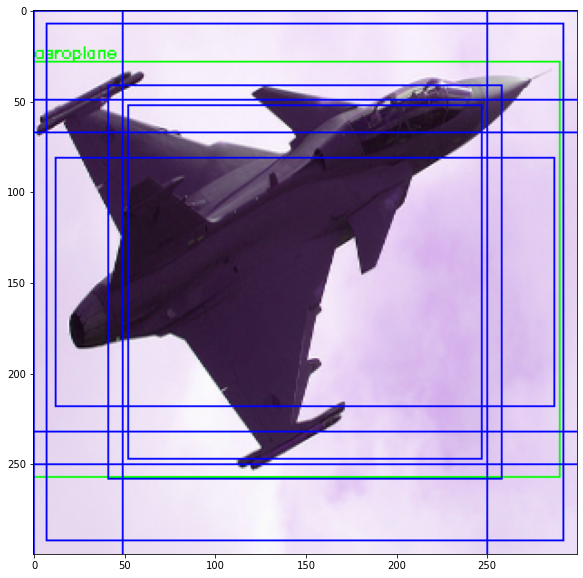

In [30]:
image, gt_labels = batch_images[0], batch_gt_labels[0]
default_boxes_minmax = to_minmaxformat(default_boxes)
target_boxes, target_classes = matching_strategy(gt_labels, default_boxes_minmax, overlap_threshold=0.5)

gt_labels_scaled = torch.cat([gt_labels[:,:-1]*voc['image_size'], gt_labels[:,-1].unsqueeze(1)], 1)
matched_defaultboxes_scaled = default_boxes_minmax[target_classes>0]*voc['image_size']

image = image.permute(1,2,0).numpy()
image = (image-image.min())/(image.max()-image.min())

fig=plt.figure(figsize=[10,10])
ax=plt.subplot(111)
show_image(ax, image, annotations=[gt_labels_scaled, matched_defaultboxes_scaled], colors=[(0,1,0), (0,0,1)], class_list=class_list)
plt.show()

## Multibox loss module

In [31]:
class MultiboxLoss(nn.Module):
  def __init__(self, default_boxes, overlap_threshold=0.5, n_classes=21, alpha=1, neg_pos_ratio=3):
    super(MultiboxLoss, self).__init__()
    self.default_boxes_cxcywh=default_boxes
    self.default_boxes_minmax=to_minmaxformat(self.default_boxes_cxcywh)
    self.overlap_threshold=overlap_threshold
    self.n_classes=n_classes
    self.alpha=alpha
    self.neg_pos_ratio=neg_pos_ratio

  def forward(self, preds, gt_labels):
    pred_offsets, pred_classes=preds
    batch_size=pred_offsets.size(0)
    n_priors=self.default_boxes_cxcywh.size(0)

    target_offsets=torch.Tensor(batch_size, n_priors, 4)
    target_classes=torch.Tensor(batch_size, n_priors)
    for i in range(batch_size):
      target_boxes, target_classes[i]=matching_strategy(gt_labels[i], self.default_boxes_minmax)
      target_boxes=to_cxcywhformat(target_boxes)
      target_offsets[i]=encode_targets(target_boxes, self.default_boxes_cxcywh)
    target_offsets=target_offsets.to(device)
    target_classes=target_classes.to(device)
    
    pos=(target_classes > 0) # positive targets
    n_pos=pos.sum(dim=1, keepdim=True)

    # localization loss
    pos_target_offsets=target_offsets[pos] # positive target offsets
    pos_pred_offsets=pred_offsets[pos] # positive pred offsets
    # localization loss is smooth l1 loss over positve predicted offsets and positive target offsets
    loss_loc=F.smooth_l1_loss(pos_pred_offsets, pos_target_offsets, reduction='sum')

    # classification loss
    # hard negative mining - keeping ratio of negative and positive examples constant
    n_hard_neg=self.neg_pos_ratio*n_pos
    loss_clf_all=F.cross_entropy(pred_classes.view(-1,self.n_classes), target_classes.view(-1).long(), reduction='none') # classification loss for all examples
    loss_clf_all=loss_clf_all.view(batch_size, n_priors)
    loss_clf_pos=loss_clf_all[pos] # classification loss for positive examples

    # retreive hard negatives
    loss_clf_neg=loss_clf_all.clone() # [batch_size, n_priors]
    loss_clf_neg[pos]=0.0
    loss_clf_neg, _=loss_clf_neg.sort(dim=1, descending=True)
    hardness_ranks=torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(loss_clf_neg)
    hard_negatives=(hardness_ranks < n_hard_neg.cpu())
    loss_clf_hard_neg=loss_clf_neg[hard_negatives]

    loss_clf=loss_clf_pos.sum() + loss_clf_hard_neg.sum()

    N=n_pos.sum().float()
    loss_clf /= N
    loss_loc /= N
    loss=loss_clf + self.alpha*loss_loc
    return loss_loc, loss_clf, loss

# Training pipeline

In [32]:
def adjust_lr(optimizer, step, gamma=0.1, lr0=1e-3):
  lr = lr0 * (gamma ** step)
  for param_group in optimizer.param_groups:
    param_group['lr']=lr

def train(model, dataloader, criterion, optimizer, max_iterations=100, lr_adjust_steps=[], save_iter_step=1, save_epoch_step=1):
  loss_loc_hist, loss_clf_hist, loss_hist=[],[],[] # store history of loss values per iteration
  
  loss_loc_hist_epoch, loss_clf_hist_epoch, loss_hist_epoch=[],[],[] # store history of loss values per epoch
  loss_loc_epoch, loss_clf_epoch, loss_epoch=0.0,0.0,0.0 # loss values per epoch
  n_train_batches=0 # total train batches in an epoch
  epoch=0
  step=0

  # set model in train mode
  model.train()
  iterator=iter(dataloader)
  
  for i in range(max_iterations):
    # adjust lr when adjustment step is reached
    if i in lr_adjust_steps:
      step += 1
      adjust_lr(optimizer, step)

    t1=time.time()
    try:
      batch_images, batch_gt_labels=next(iterator)
    except StopIteration:
      # dataloader iterator end - indicating epoch end
      loss_loc_hist_epoch.append(loss_loc_epoch/n_train_batches)
      loss_clf_hist_epoch.append(loss_clf_epoch/n_train_batches)
      loss_hist_epoch.append(loss_epoch/n_train_batches)
      loss_loc_epoch, loss_clf_epoch, loss_epoch=0.0,0.0,0.0
      n_train_batches=0

      epoch += 1
      print()
      print('\x1b[31m epoch {0}: loss_loc={1:.4f}, loss_clf={2:.4f}, loss={3:.4f} \x1b[0m'.format(epoch, loss_loc_hist_epoch[-1], loss_clf_hist_epoch[-1], loss_hist_epoch[-1]))
      if epoch%save_epoch_step==0: 
        torch.save(model.state_dict(), 'drive/My Drive/Colab/SSD_epoch_wts/ssdlite300_epoch_'+repr(epoch)+'.pth')

      # reinitialize iterator for next epoch
      iterator=iter(dataloader)
      batch_images, batch_gt_labels=next(iterator)
      
    batch_images=batch_images.to(device)
    # batch_gt_labels=[gt_label.to(device) for gt_label in batch_gt_labels]

    # forward
    batch_output=model(batch_images)
    # backporp
    optimizer.zero_grad()
    loss_loc, loss_clf, loss=criterion(batch_output, batch_gt_labels)
    loss.backward()
    optimizer.step()
    t2=time.time()

    loss_loc_hist.append(loss_loc.cpu().item())
    loss_clf_hist.append(loss_clf.cpu().item())
    loss_hist.append(loss.cpu().item())
    # accumulate losses per iteration into losses per epoch
    loss_loc_epoch += loss_loc_hist[-1]
    loss_clf_epoch += loss_clf_hist[-1]
    loss_epoch += loss_hist[-1]
    n_train_batches += 1

    print('\r{0}/{1}: loss_loc={2:.4f}, loss_clf={3:.4f}, loss={4:.4f}, iteration_time={5:.4f}'.format(i+1, max_iterations, loss_loc.cpu().item(), loss_clf.cpu().item(), loss.cpu().item(), t2-t1), end='', flush=True)
    if (i+1)%save_iter_step==0:
      torch.save(model.state_dict(), 'drive/My Drive/Colab/SSD_iteration_wts/ssdlite300_iteration_'+repr(i+1)+'.pth')
  
  torch.save(model.state_dict(), 'drive/My Drive/Colab/ssdlite300_final.pth')
  return loss_loc_hist, loss_clf_hist, loss_hist, loss_loc_hist_epoch, loss_clf_hist_epoch, loss_hist_epoch

## Setup

### Set device

In [33]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Set dataset and dataloader

In [34]:
voc_dataset=VOCDataset([VOC07_BASE_DIR, VOC12_BASE_DIR], [VOC07_TRAIN_IMAGES_DIR, VOC12_TRAIN_IMAGES_DIR], [VOC07_TRAIN_ANNOTATIONS_DIR, VOC12_TRAIN_ANNOTATIONS_DIR], image_size=voc['image_size'], transforms=SSDAugmentation())
batch_size=32
voc_dataloader=data.DataLoader(voc_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=voc_batch_collate)

### Set loss criterion

In [35]:
default_boxes_cxcywh=get_default_boxes(default_boxes_setting)
criterion=MultiboxLoss(default_boxes_cxcywh)

### Create model

In [36]:
ssd=build_MobileNetV2_SSDLite()

#### Initialize weights

In [37]:
def xavier(param):
  init.xavier_uniform_(param)

def weights_init(module):
  for m in module.modules():
    if isinstance(m, nn.Conv2d):
      xavier(m.weight.data)
      if m.bias is not None:
        m.bias.data.zero_()

##### Training from scratch

In [38]:
ssd.base_layers.apply(weights_init)
ssd.auxiliary_layers.apply(weights_init)
ssd.loc_layers.apply(weights_init)
ssd.conf_layers.apply(weights_init)

ModuleList(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(576, 576, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=576)
      (1): BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2d(576, 126, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(1280, 1280, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1280)
      (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2d(1280, 126, kernel_size=(1, 1), stride=(1, 1))
  )
  (2): Sequential(
    (0): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2d(512, 126, kernel_size=(1, 1), stride=(1, 1))
  )
  (3): S

### To device

In [39]:
ssd.to(device)

SSDLite(
  (base_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidualBottleneck(
      (operation): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidualBottleneck(
      (operation): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

### Set optimizer

In [40]:
optimizer=optim.SGD(ssd.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)

## Training loop

In [41]:
max_iterations=120000
lr_adjust_steps=[80000, 100000]
save_iter_step=20000
save_epoch_step=100

In [ ]:
loss_loc_hist, loss_clf_hist, loss_hist, loss_loc_hist_epoch, loss_clf_hist_epoch, loss_hist_epoch=train(ssd, voc_dataloader, criterion, optimizer, max_iterations=max_iterations, lr_adjust_steps=lr_adjust_steps, save_iter_step=save_iter_step, save_epoch_step=save_epoch_step)

692/120000: loss_loc=2.2793, loss_clf=4.6519, loss=6.9313, iteration_time=0.1805
 epoch 1: loss_loc=2.8662, loss_clf=6.3281, loss=9.1943 
1384/120000: loss_loc=2.2952, loss_clf=5.2548, loss=7.5500, iteration_time=0.1842
 epoch 2: loss_loc=2.3507, loss_clf=4.9590, loss=7.3097 
2076/120000: loss_loc=2.2724, loss_clf=4.0824, loss=6.3549, iteration_time=0.1966
 epoch 3: loss_loc=2.2310, loss_clf=4.6877, loss=6.9186 
2768/120000: loss_loc=1.7599, loss_clf=4.5892, loss=6.3491, iteration_time=0.1874
 epoch 4: loss_loc=2.1604, loss_clf=4.5113, loss=6.6717 
3460/120000: loss_loc=2.0609, loss_clf=4.5751, loss=6.6359, iteration_time=0.1837
 epoch 5: loss_loc=2.1044, loss_clf=4.4270, loss=6.5314 
4152/120000: loss_loc=1.7848, loss_clf=4.5297, loss=6.3145, iteration_time=0.2011
 epoch 6: loss_loc=2.0634, loss_clf=4.3820, loss=6.4454 
4844/120000: loss_loc=1.8819, loss_clf=3.9357, loss=5.8176, iteration_time=0.1964
 epoch 7: loss_loc=2.0291, loss_clf=4.3462, loss=6.3753 
5536/120000: loss_loc=2.5262

In [ ]:
fig,ax=plt.subplots(nrows=2, ncols=3, squeeze=False, figsize=[20,10])

ax[0,0].plot(range(len(loss_loc_hist)),loss_loc_hist)
ax[0,0].set_title('loc loss per iteration')
ax[0,1].plot(range(len(loss_clf_hist)),loss_clf_hist)
ax[0,1].set_title('clf loss per iteration')
ax[0,2].plot(range(len(loss_hist)),loss_hist)
ax[0,2].set_title('total loss per iteration')

ax[1,0].plot(range(len(loss_loc_hist_epoch)),loss_loc_hist_epoch)
ax[1,0].set_title('loc loss per epoch')
ax[1,1].plot(range(len(loss_clf_hist_epoch)),loss_clf_hist_epoch)
ax[1,1].set_title('clf loss per epoch')
ax[1,2].plot(range(len(loss_hist_epoch)),loss_hist_epoch)
ax[1,2].set_title('total loss per epoch')